## Project: Image Captioning

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('../data/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# initialize COCO API for instance annotations
dataDir = '/data'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=10.10s)
creating index...
index created!
loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000189714.jpg


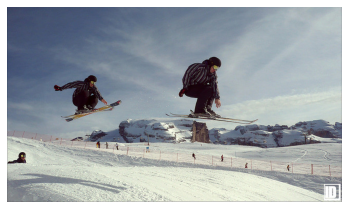

Two people that are in the air while snow skiing.
Two skiers getting air time on the slopes. 
Two skiers performing ski jumps together on downhill slope.
A group of guys skiing with a group of others in the background. 
two people jumping in the air while wearing some skiis 


In [5]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [6]:
batch_size = 512          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 300           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 10             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

In [7]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=2.44s)
creating index...


  0%|          | 599/414113 [00:00<01:09, 5981.25it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:53<00:00, 7808.29it/s]


<a id='step2'></a>
## Train your Model

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training.
For further research read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).

In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
         # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 10:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

In [ ]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.RandomRotation(90),
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

In [ ]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [ ]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-2.pkl'
decoder_file = 'decoder-2.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)